Notebook created by [Frédéric Berdoz](https://disco.ethz.ch/members/fberdoz)

Computer vision part originally created by [Peter Belcák](https://disco.ethz.ch/members/pbelcak)

Audio part originally created by [Luca Lanzendörfer](https://disco.ethz.ch/members/lucala)

Other contributor(s): [Andreas Plesner](https://disco.ethz.ch/members/aplesner), [Till Aczel](https://disco.ethz.ch/members/taczel)

In [1]:
# Uncomment for Colab
!pip install torchinfo

Today's session will first revisit some of the basics from the session #1 in more detail. There, we will show some tricks that may increase the speed at which you prototype deep neural networks.

The overreaching aim of this session is, however, to introduce you to computer vision and audio processing, mainly through convolutional neural networks. The main benefit of these networks is that they can learn far more about pictures (and also videos or sound waves) while requiring far less representational power.

If you are using Colab make sure to switch to a GPU runtime before running this notebook.
You can do this by going to Runtime > Change runtime type > Hardware accelerator > GPU.

Dig in!

# Computer Vision

Computer Vision (CV) is a field that studies how computers can gain some degree of understanding from digital images and/or video. *Understanding* in this definition has a rather broad meaning -- it can range from being able to distinguish between a cat and a dog on the picture, to more complex tasks such as describing the image in natural language.

There are several common types of computer vision tasks:

* **Image Classification** is the simplest kind, when we need to classify an image into one of many pre-defined categories, for example, distinguish a cat from a dog on a photograph, or recognise a handwritten digit.

* **Object Detection** is a slightly more difficult task, in which we need to find known objects on the picture and localise them, that is, return the **bounding box** for each of recognised objects.

* **Segmentation** is similar to object detection, but instead of giving bounding box we need to return an exact pixel map outlining each of the recognised objects.  

![An image showing how computer vision object detection can be performed with cats, dogs, and ducks.](https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/2-image-data-1.png)

Image taken from [CS224d Stanford Course](https://cs224d.stanford.edu/index.html).

Here we'll focus on the **image classification** task, and on how neural networks can be used to solve it. As with any other machine learning tasks, to train a model for classifying images we’ll need a labeled dataset, that is, a large number of images for each of the classes.

First, we will look at how images are represented as tensors.

## Images as Tensors

Computer Vision works with Images. As you probably know, images consist of pixels, so they can be thought of as a rectangular collection (array) of pixels.

In the first part of this tutorial, we will deal with handwritten digit recognition. We will use the MNIST dataset, which consists of grayscale images of handwritten digits, 28x28 pixels. Each image can be represented as 28x28 array, and elements of this array would denote intensity of corresponding pixel - either in the scale of range 0 to 1 (in which case floating point numbers are used), or 0 to 255 (integers). The popular python library `NumPy` is often used with computer vision tasks, because it allows to operate with multidimensional arrays (tensors) effectively.

To deal with color images, we need some way to represent colors. In most cases, we represent each pixel by 3 intensity values, corresponding to Red (R), Green (G) and Blue (B) components. This color encoding is called RGB, and thus color image of size $H\times W$ will be represented as an array of size $3\times H\times W$ (sometimes the order of components might be different, but the idea is the same).

![Grayscale Image](https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/2-image-data-2.png) | ![RGB Image](https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/2-image-data-3.png)
------|------
5x5 Grayscale Image | 5x5 Color (RGB) Image

Using multi-dimensional arrays to represent images also has an advantage, because we can use an extra dimension to store a sequence of images. For example, to represent a video fragment consisting of 200 colour frames/images with 800x600 dimension, we may use the tensor of size 200x3x600x800.

The following bits will remind you of the first session, in which we used FashionMNIST and MNIST datasets. Since we're familiar with these already, we'll just fly through.

### Loading the Data

In [2]:
# import the packages needed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from torchvision.transforms import ToTensor

data_train = torchvision.datasets.MNIST('./data',
        download=True, train=True, transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True, train=False, transform=ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.55MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Visualising the Dataset

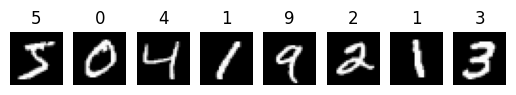

In [4]:
fig,ax = plt.subplots(1,8)
for i in range(8):
    ax[i].imshow(data_train[i][0].view(28,28), cmap='gray')
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

### Dataset Structure

We have a total of 60,000 training images and 10,000 testing images in the MNIST dataset. It's important to split out the data for training and testing. We shall do some data exploration to get a better idea of what our data looks like:

Each sample is a tuple in the following structure:
 * First element is the actual image of a digit, represented by a tensor of shape 1x28x28
 * Second element is a **label** that specifies which digit is represented by the tensor. It is a tensor that contains a number from 0 to 9.

`data_train` is a training dataset that we will use to train our model on. `data_test` is a smaller test dataset that we can use to verify our model.

In [5]:
print('Training samples:', len(data_train))
print('Test samples:', len(data_test))

print('Tensor size:', data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


All pixel intensities of the images are represented by floating-point values in between 0 and 1:

In [6]:
print('Min intensity value: ', data_train[0][0].min().item())
print('Max intensity value: ', data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


### Sidenote: Loading Your Own Images

In most of the practical applications, you would have your own images located on disk that you want to use to train your neural network. In this case, you need to load them into PyTorch tensors.

One of the ways to do that is to use one of the Python libraries for image manipulation, such as *Open CV*, or *PIL/Pillow*, or *imageio*. Once you load your image into numpy array, you can easily convert it to tensors.

> It is important to make sure that all values are scaled to the range [0..1] before you pass them to a neural network - it is the usual convention for data preparation, and all default weight initialisations in neural networks are designed to work with this range. `ToTensor` transform that we have seen above automatically scales PIL/numpy images with integer pixel values into [0..1] range.

An even easier approach is to use functionality in **torchvision** library, namely `ImageFolder`. It does all the preprocessing steps automatically, and also assigns labels to images according to the directory structure. We will see the example of using `ImageFolder` later in this notebook, once we start classifying our own cats and dogs images.

> It is important to note that for training all images should be scaled to the same size. If your original images have different aspect ratios, you need to decide how to handle this scaling - either by cropping images, or by padding extra space.

## Revisiting Dense Neural Networks

For completeness and as a baseline, we will also quickly run through some of the things you've already seen in the introductory session, just with a slightly different toolkit.

Let's focus on the problem of handwritten digit recognition. It is a classification problem, because for each input image we need to specify the class -- which digit it is.

In this section, we start with the simplest possible approach for image classification; a fully-connected neural network (which is also called a *perceptrons*). We will recap the way neural networks are defined in PyTorch, and how the training algorithm works. If you are already confident about those concepts, feel free to run through the cells towards the next section, where we introduce Convolutional Neural Networks (CNNs).

We use `pytorchcv` helper from Microsoft to load all data we have talked about above.

In [7]:
from torchinfo import summary

### Dense Neural Networks (Again)

A basic **neural network** in PyTorch consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Linear** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class).

<img alt="A graph showing how an image is broken into layers based on the pixels." src="https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/3-train-dense-neural-networks-1.png" width="60%"/>

As we discussed above, the dimension of our digit images is $1\times28\times28$, i.e. each image contains $28\times28=784$ different pixels. Because linear layer expects its input as one-dimensional vector, we need to insert another layer into the network, called **Flatten**, to change input tensor shape from $1\times28\times28$ to $784$.

After `Flatten`, there is a main linear layer (called `Dense` in PyTorch terminology) that converts 784 inputs to 10 outputs -- one per class. We want the $n$-th output of the network to return the probability of the input digit being equal to $n$.

Because the output of a fully-connected layer is not normalised to be between 0 and 1, it cannot be thought of as probability. Moreover, if want outputs to be probabilities of different digits, they all need to add up to 1. To turn output vectors into probability vector, a function called **Softmax** is often used as the last activation function in a classification neural network. For example, $\mathrm{softmax}([-1,1,2]) = [0.035,0.25,0.705]$.

> In PyTorch, we often prefer to use **LogSoftmax** function, which will also compute logarithms of output probabilities. To turn the output vector into the actual probabilities, we need to take **torch.exp** of the output.

Thus, the architecture of our network can be represented by the following sequence of layers:

<img alt="An image showing the architecture of the network broken into a sequence of layers." src="https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/3-train-dense-neural-networks-3.png" width="90%"/>

It can be defined in PyTorch in the following way, using `Sequential` syntax:

In [8]:
net = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784, 10), # 784 inputs, 10 outputs
  nn.LogSoftmax(dim=1)
)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = net.to(device)

This sequence of layers is shown below in more detail. For all vectors in this diagram we also indicate tensor size.

<img alt="An image showing the architecture of the network broken into a sequence of layers." src="https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/3-train-dense-neural-networks-2.png" width="90%"/>

On the right hand side of this diagram we also have expected network output, represented as one-hot encoded vector. Expected output is compared with the actual output of our network using **loss function**, that gives one number -- loss -- as an output. Our goal during network training is to minimise this loss by adjusting model parameters - layer weights.

### Training the Network

A network defined in this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our dataset:

In [9]:
print('Digit to be predicted: ', data_train[0][1])
torch.exp(net(data_train[0][0].to(device))).cpu()

Digit to be predicted:  5


tensor([[0.0871, 0.0955, 0.0911, 0.1148, 0.1121, 0.1094, 0.0876, 0.0924, 0.1105,
         0.0995]], grad_fn=<ToCopyBackward0>)

> Because we use `LogSoftmax` as final activation of our network, we pass network output through `torch.exp` to get probabilities.

As you can see the network predicts similar probabilities for each digit. This is because it has not been trained on how to recognise the digits. We need to give it our training data to train it on our dataset.

To train the model we will need to create **batches** from our dataset of a certain size, let's say 64. PyTorch has an object called **DataLoader** that can create batches of our data for us automatically:

In [10]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64) # we can also use larger batch sizes for testing

In [11]:
def train_epoch(net, dataloader, device, lr=0.01, optimiser=None, loss_fn = nn.NLLLoss()):
    optimiser = optimiser or torch.optim.Adam(net.parameters(), lr=lr)
    # Ensure the network is in training mode
    net.train()
    total_loss, acc, count = 0,0,0
    for features,labels in dataloader:
        # Ensure features/images and labels are on the correct device
        features, labels = features.to(device), labels.to(device)
        # Predict outputs for features and compute the loss between predictions
        # and labels
        out = net(features)
        loss = loss_fn(out, labels)
        total_loss += loss

        # Zero gradients from earlier computations
        optimiser.zero_grad()
        # Compute gradients for weights
        loss.backward()
        # Do optimiser step
        optimiser.step()

        # Get predicted classes as the entry with the highest probability
        _, predicted = torch.max(out, 1)
        # Compute accuracy
        acc += (predicted == labels).sum().cpu()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net, train_loader, device)

(0.005932000732421875, 0.8929833333333334)

Since this function is pretty generic we will be able to use it later in our other examples. The function takes the following parameters:
* **Neural network**
* **DataLoader**, which defines the data to train on
* **Loss Function**, which is a function that measures the difference between the expected result and the one produced by the network. In most of the classification tasks `NLLLoss` is used, so we will make it a default.
* **Optimiser**, which defined an *optimisation algorithm*. The most traditional algorithm is *stochastic gradient descent*, but we will use a more advanced version called **Adam** by default.
* **Learning rate** defines the speed at which the network learns. During learning, we show the same data multiple times, and each time weights are adjusted. If the learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would perform badly. If the learning rate is too small it results in a very slow learning process.

Here is what we do when training:
* Switch the network to training mode (`net.train()`). This ensures that modules (like dropout, batch norm) that behave differently in training and inference use the correct mode.
* Go over all batches in the dataset, and for each batch do the following:
   - compute predictions made by the network on this batch (`out`)
   - compute `loss`, which is the discrepancy between predicted and expected values
   - `loss.backward()` computes the gradient
   - try to minimise the loss by taking a step in the opposite gradient direction, therefore adjusting weights of the network (`optimiser.step()`)
   - compute the number of correctly predicted cases (**accuracy**)

The function calculates and returns the average loss per data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether the network is improving and learning from the data provided.

It is also important to control the accuracy on the test dataset (also called **validation accuracy**). A good neural network with a lot of parameters can predict with decent accuracy on any training dataset, but it may poorly generalise to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset:


In [12]:
def validate_epoch(net, dataloader, device, loss_fn=nn.NLLLoss()):
    # Ensure network is in evaluation mode
    net.eval()
    count,acc,loss = 0,0,0
    # We use torch.no_grad() to remove gradient computations
    # This is not necessary, but can be much faster
    with torch.no_grad():
        for features,labels in dataloader:
            # Ensure features and labels are on the correct device
            features = features.to(device)
            labels = labels.to(device)
            # Make predictions
            out = net(features)
            # Compute loss and accuracy of the model
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate_epoch(net, test_loader, device)

(0.00585538444519043, 0.8938)

Similarly to `train` function, we return average loss and accuracy on test dataset.

### Overfitting

Normally when training a neural network, we train the model for several epochs observing training and validation accuracy. In the beginning, both training and validation accuracy should increase (quickly), as the network picks up the patterns in the dataset. However, at some point it can happen that training accuracy increases while validation accuracy starts to decrease. That would be an indication of **overfitting**, that is model does well on your training dataset, but not on new data.

Below is the training function that can be used to perform both training and validation. It prints the training and validation accuracy for each epoch, and also returns the history that can be used to plot the loss and accuracy on the graph.

In [14]:
def train(net, train_loader, test_loader, device=torch.device('cpu'), optimiser=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimiser = optimiser or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(
            net=net,
            dataloader=train_loader,
            device=device,
            optimiser=optimiser, lr=lr, loss_fn=loss_fn)
        vl,va = validate_epoch(
            net=net,
            dataloader=test_loader,
            device=device,
            loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [15]:
# Re-initialize the network to start from scratch
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
    nn.LogSoftmax(dim=1)
).to(device)

# This will take a minute or two
hist = train(
    net=net,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=10
)

Epoch  0, Train acc=0.893, Val acc=0.894, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.898, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  5, Train acc=0.917, Val acc=0.895, Train loss=0.005, Val loss=0.006
Epoch  6, Train acc=0.918, Val acc=0.893, Train loss=0.005, Val loss=0.007
Epoch  7, Train acc=0.919, Val acc=0.892, Train loss=0.005, Val loss=0.007
Epoch  8, Train acc=0.919, Val acc=0.891, Train loss=0.005, Val loss=0.007
Epoch  9, Train acc=0.919, Val acc=0.890, Train loss=0.005, Val loss=0.007


This function logs messages with the accuracy on training and validation data from each epoch. It also returns this data as a dictionary (called **history**). We can then visualize this data to better understand our model training.

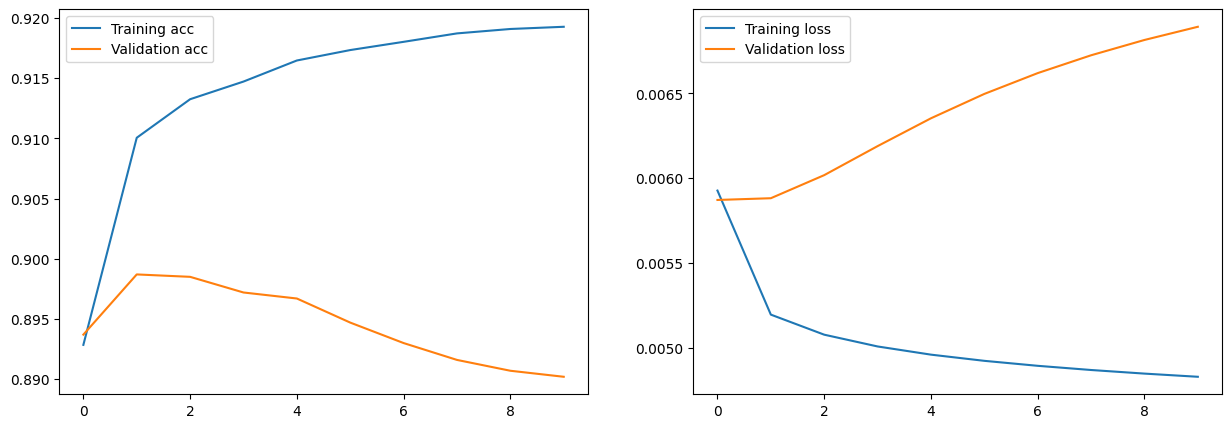

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


Discuss overfitting with yourself or your partner for two minutes.

When does it happen?

Why does it happen?

### Visualising Network Weights

The `Dense` layer in our network is also called *linear*, because it performs linear transformation of its input, which can be defined as $y=Wx+b$, where $W$ is a matrix of weights, and $b$ is bias. Weights matrix $W$ is in fact responsible for what our network can do, i.e. for recognising digits. In our case, it has size of $784\times10$, because it produces 10 outputs (one output per digit) for an input image.

Let's visualise our weights of our neural network and see what they look like. When the network is more complex than just one layer it can be a difficult to visualise the results like this, because in complex network weights do not make much sense when visualised. However, in our case each of 10 dimensions of weight matrix $W$ correspond to individual digits, and thus can be visualised to see how the digit recognition takes place. For example, if we want to see if our number is 0 or not, we will multiply input digit by $W[0]$ and pass the result through a softmax normalisation to get the answer.

In the code below, we will first get the matrix $W$ into `weight_tensor` variable. It can be obtained by calling the `net.parameters()` method (which returns both $W$ and $b$), and then calling `next` to get the first of two parameters. Then we will go over each dimension, reshape it to $28\times28$ size, and plot.

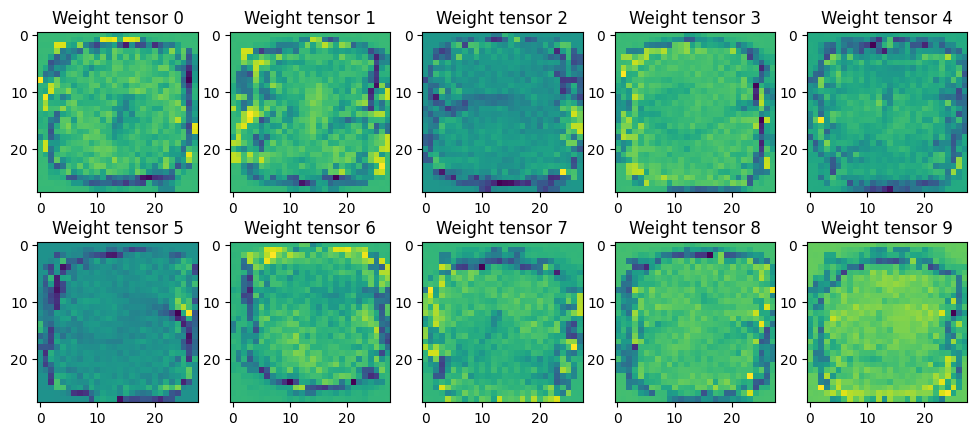

In [17]:
weight_tensor = next(net.parameters())
fig, axes = plt.subplots(2,5,figsize=(12,5))
axes = axes.flatten()
for i,x in enumerate(weight_tensor):
    axes[i].imshow(x.view(28,28).cpu().detach())
    axes[i].set_title(f"Weight tensor {i}")

#### **Exercise 1**
Stop for a second and try to interpret the pictures of the weight. Can you say anything about the functions of individual linear neurons? I.e., can you say anything about what sort of information they attempt to capture from the inputs? Discuss among yourselves and talk to TAs.

### Deeper Networks

As you might remember, having more neurons and multiple layers of neurons relying on each other together with non-linear activations grants neural networks further *representational power* -- that is, the ability to learn more, or to learn about its input more precisely. These layers beyond the output layer are called *hidden layers*.

<img alt="An image showing a multi-layer network with a hidden layer between the input layer and the output layer" src="https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/3-train-dense-neural-networks-4.png" width="70%"/>

Let's investigate an example deep neural network, depicted below:

<img alt="An image showing the network layer structure as it's broken down into layers" src="https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/3-train-dense-neural-networks-5.png" width="70%"/>

This network can be quickly defined in PyTorch with the following code:



In [18]:
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Here we use `summary()` function to display a detailed layer-by-layer structure of a network with some other useful information. In particular, we can see:

* Layer-by-layer structure of a network, and output size of each layer
* Number of parameters of each layer, as well as for the whole network. As an approximate rule of thumb that is also a gross oversimplification, the more parameters the network has, the more data samples it needs to be trained on without **overfitting**.

Let's see how the number of parameters is calculated. First linear layer has 784 inputs and 100 outputs. The layer is defined by $W_1\times x+b_1$, where $W_1$ has size $784\times100$, and $b_1$ - $100$. Thus total number of parameters for this layer is $784\times100+100 = 78500$. Similarly, number of parameters for the second layer is $100\times10+10 = 1010$. Activation functions, as well as `Flatten` layers do not have parameters.

There is another syntax that we already used in the first seession to define the same network by using Python classes:

In [19]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)
        # Apply the hidden linear layer
        x = self.hidden(x)
        # Apply relu activation function
        x = relu(x)
        # Apply the output linear layer
        x = self.out(x)
        # Apply the log_softmax function to get log probabilities
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

summary(net, input_size=(1,28,28),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

You can see that the structure of a neural network is the same as with the `Sequential`-defined network, but the definition is more explicit. Our custom neural network is represented by a class inherited from ``torch.nn.Module`` class.

Class definition consists of two parts:
* In the constructor (`__init__`) we define all layers that our network will have. Those layers are stored as internal variables of the class, and PyTorch will automatically know that parameters of those layers should be optimised when training. Internally, PyTorch uses `parameters()` method to look for all trainable parameters, and `nn.Module` will automatically collect all trainable parameters from all sub-modules.
* We define the `forward` method that does the forward pass computation of our neural network. In our case, we start with a parameter tensor `x`, and explicitly pass it through all the layers and activation functions, starting from `flatten`, up to final linear layer `out`. When we apply our neural network to some input data `x` by writing `out = net(x)`, the `forward` method is called.

In fact, `Sequential` networks are represented in a very similar manner, they just store a list of layers and apply them sequentially during the forward pass. Here we have a chance to represent this process more explicitly, which eventually gives us more flexibility. That is one of the reasons that using classes for neural network definition is a recommended and preferred practice.
`Sequential` can also be used in the class definition which can make the code simpler.

You can now try to train this network using exactly the same `train` function that we've defined above:

In [20]:
import matplotlib.pyplot as plt

def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()


Epoch  0, Train acc=0.928, Val acc=0.950, Train loss=0.035, Val loss=0.033
Epoch  1, Train acc=0.951, Val acc=0.950, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.956, Val acc=0.958, Train loss=0.033, Val loss=0.033
Epoch  3, Train acc=0.959, Val acc=0.956, Train loss=0.033, Val loss=0.033
Epoch  4, Train acc=0.962, Val acc=0.963, Train loss=0.033, Val loss=0.033


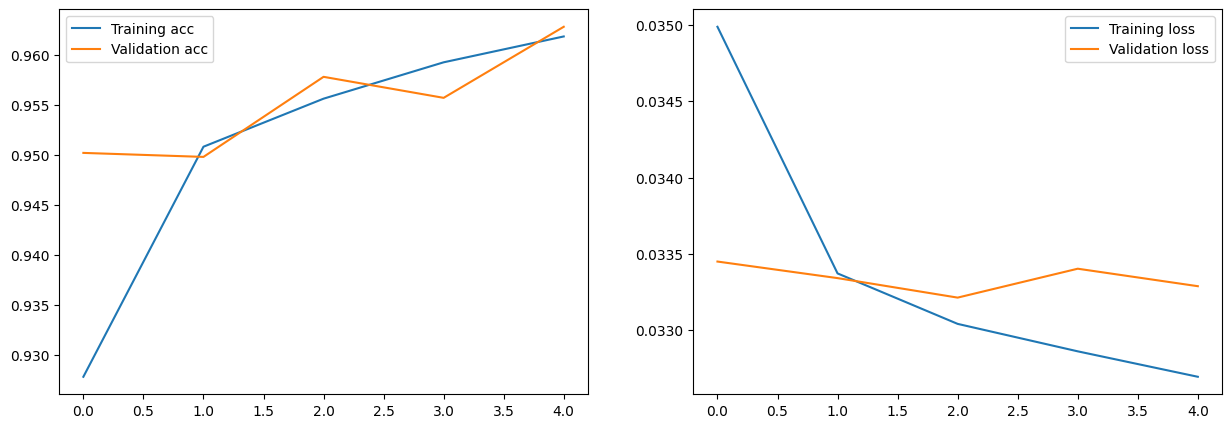

In [21]:
hist = train(net, train_loader, test_loader, device=torch.device('cpu'), epochs=5)
plot_results(hist)

#### **Exercise 2**
How do the results above compare to the earlier results using only a single linear layer?

*Write your answer here (double-click to edit)*



## Convolutional Neural Networks

In the previous section, we have learned how to define a multi-layered neural network using class definition, but those networks were generic, and not specialised for computer vision tasks. In this section, we shall learn about **Convolutional Neural Networks (CNNs)**, which are specifically designed for computer vision.

Computer vision classification problems can be viewed as a class of special cases of general classification, because when trying to find a certain object in the picture, one is scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, one may first look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell them that it is actually a picture of a cat. Relative position and presence of certain patterns is what plays the decisive role in this example, not their exact position on the image.

To understand CNNs we need to understand convolutional layers which consist of convolutional filters.

### Convolutional Filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted sum of the neighboring pixels.

<img alt="Sliging window over 28x28 digit image" src="https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/4-convolutional-networks-1.png" width="50%"/>

It can be understood as for each pixel in the picture you take the element-wise product between the pixel's neighbourhood and the filter and compute the sum.

They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets

def plot_convolution(t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = data_train[i][0]
            ax[0][i].imshow(im[0])
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0])
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        #plt.tight_layout()
        plt.show()


In [ ]:
plot_convolution(torch.tensor([[-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.]]), 'Vertical edge filter')
plot_convolution(torch.tensor([[-1., -1., -1.], [0., 0., 0.], [1., 1., 1.]]), 'Horizontal edge filter')


First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

> If we apply $3\times3$ filter to an image of size $28\times28$ - the size of the image will become $26\times26$, because the filter does not go over the image boundaries. In some cases, however, we may want to keep the size of the image the same, in which case image is padded with, e.g., zeros on each side.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problems.

To do that, we introduce **convolutional layers**.

### Covolutional Layers



Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:
* `in_channels` - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1. Color image has 3 channels (RGB).
* `out_channels` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used. The choice of filter size is usually chosen by experiment, that is by trying out different filter sizes and comparing resulting accuracy.

> For convolutional layers, if you have data of shape $C \times W \times H$ then it is $W$ by $H$ images with $C$ channels. Colour images have three channels while gray scale images have one channel. In the hidden layers the image might have many channels.

The simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels). Here the result of each filter is represented by a different channel in the image (thus the first dimension 9 corresponds to the number of filters).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers.

In [ ]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()

        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x

net = OneConv()

summary(net, input_size=(1, 1, 28, 28))

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalise considerably better.

> Note that the number of parameters of convolutional layer is quite small, and it *does not depend on the resolution of the image*! In our case, we were using 9 filters of dimension $5\times5$, thus the number of parameters is $9\times5\times5+9=234$. We omitted this in our discussion above, but convolutional filters also have a bias. Most of the parameters of our network comes from the final `Dense` layer.

In [ ]:
hist = train(net, train_loader, test_loader, epochs=5, device=device)
plot_results(hist)

#### **Exercise 3**
How does the CNN compare to the previous models in terms of overfitting?

*Write your answer here (double-click to edit)*


As you can see, we are able to achieve higher accuracy, and much faster, compared to the fully-connected networks from previous unit.

We can also visualise the weights of our trained convolutional layers, to try and make some more sense of what is going on:

In [ ]:
fig,ax = plt.subplots(3, 3, figsize=(6,6))
ax = ax.flatten()
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')
        ax[i].set_title(f'Filter {i}')

#### **Exercise 4**
What do you get out from the plot above? Discuss with yourself or your partner

*Write your answer here (double-click to edit)*


### Multi-Layered CNNs

The section above has introduced the convolutional filters; filters that can extract patterns from images. For our MNIST classifier we used 9 5x5 filters, resulting in 9x24x24 tensor.

We can use the same idea of convolution to extract higher-level patterns in the image. For example, rounded edges of digits such as 8 and 9 can be composed from a number of smaller strokes. To recognise those patterns, we can build another layer of convolution filters on top of the result of the first layer.

### Pooling Layers

First convolutional layers looks for primitive patterns, such as horizontal or vertical lines. Next level of convolutional layers on top of them look for higher-level patterns, such as primitive shapes. More convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify. This creates a hierarchy of extracted patterns.

When doing so, we also need to apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within a sliding window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the **pooling layers**:

 * **Average Pooling** takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window
 * **Max Pooling** replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

<img alt="Max Pooling" src="https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/5-multilayer-convolutions-1.png" width="50%"/>

Thus, in a typical CNN there would be several convolutional layers, with pooling layers in between them to decrease the dimensions of the images. We would also increase the number of filters, because as patterns become more advanced; there are more possible interesting combinations that we need to be looking for.

![An image showing several convolutional layers with pooling layers.](https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/images/5-multilayer-convolutions-2.png)

Because of decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called **pyramid architecture**.

In the next example, we will use a two-layered CNN:

In [ ]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x

net = MultiLayerCNN()
summary(net, input_size=(1, 1, 28, 28))

Note a few things about the definition:
* Instead of using `Flatten` layer, we are flattening the tensor inside `forward` function using `view` function, which is similar to `reshape` function in numpy. Since flattening does not have trainable weights, it is not required that we create a separate layer instance within our class - we can just use a function from `torch.nn.functional` namespace.
* We use just one instance of a pooling layer in our model, since it does not contain any trainable parameters, and thus one instance can be effectively reused.
* The number of trainable parameters (~8.5K) is dramatically smaller than in previous cases (80K in Perceptron, 50K in one-layer CNN). This happens because convolutional layers in general have few parameters, independent of the input image size. Also, due to pooling, dimensionality of the image is significantly reduced before applying the final dense layer. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

In [ ]:
hist = train(net, train_loader, test_loader, epochs=5, device=device)

#### **Exercise 5**
Modify the above code to run the example for 10 epochs and plot the training history.

In [ ]:
# your code goes here

What you should probably observe is that we are able to achieve higher accuracy, and much faster, just with 1 or 2 epochs. It means that a more sophisticated network architecture may need much less data to figure out what is going on, and to extract generic patterns from our images.

### Playing with Real Images from the CIFAR-10 Dataset

While our handwritten digit recognition problem may seem like a toy problem, we are now ready to do something more serious. Let's explore more advanced dataset of pictures of different objects, called [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). It contains 60k 32x32 color images, divided into 10 classes.

In [ ]:
# We load in the image and apply this transform to them. Firstly, convert to a tensor.
# Secondly, normalize the three channels by substracting 0.5 and dividing by 0.5.
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])

display_dataset(trainset,classes=classes)

A well-known architecture for CIFAR-10 is called [LeNet](https://en.wikipedia.org/wiki/LeNet), and has been proposed by *Yann LeCun*. It follows the same principles as we have outlined above. However, since all images are color, input tensor size is $3\times32\times32$, and the $5\times5$ convolutional filter is applied across color dimension as well - meaning that the size of convolution kernel matrix is $3\times5\times5$.

We also do one more simplification to this model - we do not use `log_softmax` as output activation function, and just return the output of last fully-connected layer. In this case we can just use `CrossEntropyLoss` loss, which is a composition of log-sfotmax and negative log lieklyhood loss function to optimise the model.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet().to(device)

summary(net,input_size=(1,3,32,32))

Training this network properly will take significant amount of time, and should preferably be done on GPUs.

> In order to achieve better training results, we may need to experiment with some training parameters, such as learning rate. Thus, we explicitly define a *stochastic gradient descent* (SGD) optimiser with momentum here, and pass training parameters. You can adjust those parameters and observe how they affect training.

In [ ]:
# Create an optimiser using SGD with a learning rate of 1e-3 and momentum of 0.9
opt = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
hist = train(net, trainloader, testloader, device=device, epochs=3, optimiser=opt, loss_fn=nn.CrossEntropyLoss())

The accuracy that we have been able to achieve with 3 epochs of training does not seem great. However, remember that blind guessing would only give us 10% accuracy, and that our problem is actually significantly more difficult than MNIST digit classification. Getting above 50% accuracy in such a short training time seems like a good accomplishment.

#### **Exercise 6**
Below is a diagram comparing `LeNet` and `AlexNet` ([paper](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)). Implement a class `AlexNet` as a subclass of `nn.Module`. The cell must result in a successful output of the network summary. Discuss your implementation with the TAs at hand.

![LeNet vs AlexNet.](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/480px-Comparison_image_neural_networks.svg.png)

In [ ]:
class AlexNet(nn.Module):
  pass # your code goes here

alex_net_instance = AlexNet()
summary(alex_net_instance, input_size=(1, 3, 224, 224))

## Pre-Trained Modules and Transfer Learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called transfer learning, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as ImageNet. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [ ]:
import os
import torchvision.transforms as transforms

### Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time (minutes not seconds)!):

In [ ]:
import os
import zipfile
import urllib.request
import glob
from PIL import Image  # Add this import to handle image operations

# Download and extract if not present
zip_path = 'data/kagglecatsanddogs_5340.zip'
extract_path = 'data/PetImages'
if not os.path.exists(zip_path):
    urllib.request.urlretrieve('https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip', zip_path)
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')

# Check image files
def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()  # Verify the integrity of the image
        return True
    except:
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print(f"Corrupt image: {fn}")
            os.remove(fn)

# Check Cat and Dog images
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')


Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalisation. We define image transformation pipeline by composing several primitive transformations using `Compose`:
* `Resize` resizes our image to 256x256 dimensions
* `CenterCrop` gets the central part of the image with size 224x224. Pre-trained VGG network has been trained on 224x224 images, thus we need to bring our dataset to this size.
* `ToTensor` normalises pixel intensities to be in `[0, 1]` range, and convert images to PyTorch tensors
* `std_normalise` transform is additional normalisation step specific for VGG network. When training a VGG network, original images from ImageNet were transformed by subtracting dataset mean intensity by color and dividing by standard deviation (also by color). Thus, we need to apply the same transformation to our dataset, so that all images are processed correctly.

There are a few reason why we resized images to size 256, and then cropped to 224 pixels:
* We wanted to demonstrate more possible transformations.
* Pets are usually somewhere in the central part of the image, so we can improve classification by focusing more on the central part
* Since some of the images are not square, we end up having padded parts of the image that do not contain any useful picture data, and cropping the image a bit reduces the padded part.

In [ ]:
std_normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        std_normalise
])
dataset = torchvision.datasets.ImageFolder('data/PetImages', transform=trans)
trainset_size = int(0.8*len(dataset))
trainset, testset = torch.utils.data.random_split(dataset, [trainset_size, len(dataset) - trainset_size])

display_dataset(testset, n=15, classes=["Cat", "Dog"])

### Pre-Trained Models

There are many different pre-trained models available inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [ ]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

The result that we have received is a number of an `ImageNet` class, which can be looked up [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can use the following code to automatically load this class table and return the result:

In [ ]:
import json, requests
class_map = json.loads(requests.get("https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

In [ ]:
summary(vgg, input_size=(1, 3, 224, 224))

#### **Exercise 7**
Compare your implementation of `AlexNet` with `VGG-16`. What are three main differences that you can spot? Talk to the TAs about them.

*Write your answer here (double-click to edit)*


### GPU Computations

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

The way it is normally done is to check the availability of GPU in the code, and define `device` variable that points to the computational device - either GPU or CPU.

First, make sure that you have GPUs/TPUs enabled in your Colab though. You can do so under `Runtime > Change runtime type > Hardware accelerator` in the top bar menus.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

### Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

In [ ]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15, 3))
plt.imshow(res.detach().view(-1, 512))
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualise it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [ ]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

In [ ]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset, [700, 100])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

net = torch.nn.Sequential(
    torch.nn.Linear(512*7*7, 2),
    torch.nn.LogSoftmax(dim=1)
).to(device)

history = train(net, train_loader, test_loader, device=device)

The results are great, we can distinguish between a cat and a dog with 99% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.

### Transfer Learning Using One VGG Network

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [ ]:
print(vgg)

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

In [ ]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use the `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

> **Note:** If you are interested in the implementation of the `train_long` function, refer to the `pytorchcv.py` file.

In [ ]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(device)
            out = net(features.to(device))
            loss += loss_fn(out,lbls)
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count


def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(device)
            optimizer.zero_grad()
            out = net(features.to(device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

It looks like we have obtained reasonably accurate cats vs. dogs classifier! Let's save it for future use!

In [ ]:
torch.save(vgg,'data/cats_dogs.pth')

We can then load the model from file at any time. You may find it useful in case the next experiment destroys the model - you would not have to re-start from scratch.

In [ ]:
vgg = torch.load('data/cats_dogs.pth')

### Fine-Tuning Transfer Learning

In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen.

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

In [ ]:
for x in vgg.features.parameters():
    x.requires_grad = True

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimise the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

> **Note:** The learning rate is now much lower to not destroy the earlier solution.

In [ ]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

### Other Computer Vision Models

VGG-16 is one of the simplest computer vision architectures. `torchvision` package provides many more [pre-trained networks](https://pytorch.org/vision/stable/models.html). The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

In [ ]:
resnet = torchvision.models.resnet18()
print(resnet)

As you can see, the model contains the same building blocks: feature extractor and fully-connected layer(`fc`). This allows us to use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.

This network also contains yet another type of layer: **Batch Normalisation**. The idea of batch normalisation is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalise our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalisation layer computes average and standard deviation for all values of the current minibatch, and uses them to normalise the signal before passing it through a neural network layer. This considerably improves the stability of deep networks.


### The Transfer Learning Takeaway

Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and achieve high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognise cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy on more exotic, domain-specific objects, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks that we are solving now require higher computational power, and cannot be easily solved on the CPU. Below, we will try to use more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy.

# Audio

The second part of this session will focus on the combination of audio and machine learning. We will first cover different aspects of audio preprocessing and later on classify musical genres. We will use some of the concepts seen in the computer vision part of the notebook, in particular convolution.

The goal of this session is to get hands-on experience working with audio data in machine learning and to obtain a glimpse into the applications of machine learning within the audio domain.

Parts of this notebook were taken from [Valerio Velardo's ML for Audio Youtube playlist](https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0), [the tutorial on supervised music classification](https://music-classification.github.io/tutorial/part3_supervised/tutorial.html) and [torchaudio's feature extraction tutorial](https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py)

## Introduction

Before we dig into the machine learning aspects of audio processing let's first revisit some fundamentals of audio.

We will demonstrate this using the `librosa` library and a built-in demo of a five second trumpet snippet. Let's import the necessary libraries and load the audio file.

In [ ]:
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Audio
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from tqdm import tqdm
import soundfile as sf
import torch

In [ ]:
filename = librosa.ex('trumpet')

We can load an audio file using `librosa.load`, here we need to pass two arguments, the sampling rate and whether the sound should be mono.

By specifying `sr=None` we ensure that the file is loaded with the native sampling rate. `mono=True` is usually used as it makes everything easier. Just like in Computer Vision, where grayscale makes life easier, mono channel audio allows us to work with a single channel. If the audio is multi channel, it is usually averaged into a single channel.

> Note: Sampling rate is the number of samples per second from a signal. The higher the sampling rate, the more information is captured. However, the higher the sampling rate, the more memory is required to store the audio file. The sampling rate is usually 44.1 kHz or 48 kHz for CD quality audio. This value is also used for the Nyquist frequency, which is the highest frequency that can be represented in a signal. For example, if the sampling rate is 44.1 kHz, the Nyquist frequency is 22.05 kHz. This means that the highest frequency that can be represented in the signal without aliasing is 22.05 kHz. Aliasing occurs when the signal is distorted due to the sampling rate being too low. The Nyquist frequency is half the sampling rate and strategically chosen to include the highest frequencies audible to humans, which is around 20 kHz.

In [ ]:
trumpet, sr = librosa.load(filename, sr=None, mono=True)

We are now ready to work on the soundwave contained in `trumpet`, the `sr` lets us check what sampling rate we are working with. We are expecting `trumpet` to contain a single array of values, the length of the array is determined by the length of the audio snippet multiplied by the sampling rate.

In [ ]:
print(trumpet.shape)
print(sr)

Nice! According to the formula this snippet should contain $117601 / 22050$ seconds of audio. This turns out to be 5.33 seconds.

Let's load this array into `Audio` and give it a listen. `Audio` is provided by `IPython.display`. A handy package that allows various features directly within a jupyter notebook.

In [ ]:
Audio(trumpet, rate=sr)

Exquisite. The length of the snippet checks out as well, very good.

## Audio visualization
Let's visualize this snippet. First, we will write a little helper function to plot a waveform, in case we need it again later.

In [ ]:
def plot_waveform(waveform, sr, title="Waveform"):
    if torch.is_tensor(waveform):
        waveform = waveform.numpy()
        _, num_frames = waveform.shape
        waveform = waveform[0]
    else:
        num_frames = len(waveform)
    time_axis = np.arange(0, num_frames) / sr

    figure, axes = plt.subplots(1, 1)
    axes.plot(time_axis, waveform, linewidth=1)
    axes.grid(True)
    axes.set_xlabel("Time (s)")
    axes.set_ylabel("Amplitude")
    figure.suptitle(title)
    plt.show(block=False)

The `plot_waveform` function is a bit more complicated than it needs to be. This allows us to plot both numpy and torch arrays in one function. It will come in handy later on.

Let's now plot the soundwave of the trumpet.

In [ ]:
plot_waveform(trumpet, sr, title="Trumpet")

The soundwave is a representation of the amplitude of the sound over time. The amplitude is the strength of the sound wave. The higher the amplitude, the louder the sound.

In audio processing for ML we usually work with spectrograms. A spectrogram is a two-dimensional representation of the signal, where the x-axis is time and the y-axis is frequency. The color of the spectrogram represents the intensity of the signal at a given time and frequency. The spectrogram is a very useful tool for analyzing audio signals.

It turns out that spectrograms containing frequencies and temporal information can be generated using a variation of the Fourier Transform: Short-Time Fourier Transform!

Short-Time Fourier Transform is basically the same as a normal discrete Fourier Transform but applied only to short segments of the signal. We need this because, applying a discrete Fourier Transform to the entire soundwave would average out all the frequencies over time and essentially remove the temporal component of the signal.

STFT has a couple of parameters that are usually set:
- window length: Width of the window that masks the signal at time $t$, a small window will improve temporal resolution, but at the cost of spatial resolution. This is known as the time-frequency localization trade-off. Therefore, what values are best depend on the signal and the application, there is no free lunch!
- hop length: Distance between adjacent segments.
- n_fft: Length of the windowed signal after padding. Usually the window length and n_fft are set to be the same value. Depending on the application different values are recommended, for speech 512 and for music 2048.

![Alt text](https://www.researchgate.net/publication/346243843/figure/fig1/AS:961807523000322@1606324191138/Short-time-Fourier-transform-STFT-overview.png)

Image taken from [Area-Efficient Short-Time Fourier Transform Processor for Time–Frequency Analysis of Non-Stationary Signals](https://www.mdpi.com/2076-3417/10/20/7208)

Let's start by using `librosa.stft`, the built-in function for Short-Time Fourier Transform, to obtain a complex-valued matrix for our audio snippet. We define the parameters, so that we can easily reuse them later on.

In [ ]:
N_FFT = 2048
HOP_LENGTH = 512
WIN_LENGTH = 2048

In [ ]:
stft_trumpet = librosa.stft(trumpet, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)

`stft_trumpet` is a matrix with dimension `[1+n_fft/2, len(signal)/hop_length]`. It contains (for our chosen parameters) 1025 frequency bins and 230 frames.

In [ ]:
print(stft_trumpet.shape)
print(stft_trumpet.dtype)

However, because each entry is a complex value, we cannot yet visualize our trumpet matrix. The usual approach to solve this, is to compute the squared magnitude for each value. This is also known as the power spectrogram.

In [ ]:
power_trumpet = np.abs(stft_trumpet) ** 2
print(power_trumpet.shape)
print(power_trumpet.dtype)

So, now that we have float values we can plot our matrix. We will define a `plot_spectrogram` function for easy reuse.

In [ ]:
def plot_spectrogram(specgram, title=None, yscale="linear", ylabel="Hz"):
    fig, axs = plt.subplots(1, 1)
    plt.title(title or "Spectrogram (db)")
    librosa.display.specshow(specgram, y_axis=yscale, x_axis='time')
    if "dB" in title or "Mel" in title:
        plt.colorbar(ax=axs, format="%+2.f dB")
    else:
        plt.colorbar(ax=axs)
    fig.gca().set_ylabel(ylabel)
    plt.show(block=False)

In [ ]:
plot_spectrogram(power_trumpet, "Power Spectrogram")

We can faintly make out a signal in the first two hundred frequency bins. Let's modify this. Converting the power spectrogram to decibel, which is a simple log transformation is done using the built in function `power_to_db` in `librosa`. This makes sense since the human hearing perceives frequencies not linearly, but logarithmically.

> Note: The decibel scale is used to measure sound pressure levels. The decibel scale is a logarithmic scale, which means that a 10 dB increase is not twice as loud, but 10 times as loud.

In [ ]:
plot_spectrogram(librosa.power_to_db(power_trumpet), "dB Spectrogram")

This is already better, we can observe the energy of the different frequencies over time.

We have already changed the values of our matrix to better reflect human hearing, but the frequency bins are still displayed linearly. A logarithmic scale on the y-axis would be closer to how we perceive the various frequencies. Let's change that.

In [ ]:
plot_spectrogram(librosa.power_to_db(power_trumpet), "Log-Frequency dB Spectrogram", "log")

Nice! The fundamental frequency and the harmonic components are now clearly visible.

> Note: The fundamental frequency is the lowest frequency in a sound. The harmonics are the frequencies that are integer multiples of the fundamental frequency.

## Mel-Spectrogram

We have almost made it to the final form of spectrogram that we want for our audio processing. There is one more step to go: Mel-Spectrogram.

Every spectrogram we looked at so far used frequencies measured in Hertz. This is a bit problematic for human hearing. Frequencies are spaced linearly but our hearing has a fundamentally different perception. Our hearing can distinguish lower frequencies better compared to higher frequencies, this relationship is also logarithmic.

Mel-Spectrograms solve this problem by converting frequencies into Mels. The Mel-scale is a perceptual scale of pitches judged by listeners to be equal in distance from one another. It is a nonlinear transformation of the frequency scale. The Mel-scale is defined as:

![Alt text](https://www.sfu.ca/sonic-studio-webdav/handbook/Graphics/Mel.gif)

Image taken from [sfu.ca](https://www.sfu.ca/sonic-studio-webdav/handbook/Mel.html)

The conversion is given by the following equations:
- $m = 2595 * log(1+f/500)$
- $f = 700*(10^{m/2595}-1)$

To convert frequencies to Mel-scale we need one parameter: Mel bands.

Mel bands are the equivalent to the frequency bins in a frequency spectrogram but for the Mel-Spectrogram. So how many mel bands should we use? That depends on the application, general numbers are between 40 and 128.

Let's now generate our trumpet Mel-Spectrogram.

> Note: Next to Mel bands we also need Mel Filter Banks. MFBs are a set of triangular filters that are used to convert the frequency spectrogram into a Mel-Spectrogram. The Mel-Spectrogram is then obtained by multiplying the Mel Filter Banks with the frequency spectrogram.

In [ ]:
N_MELS = 128

In [ ]:
mel_trumpet = librosa.feature.melspectrogram(y=trumpet, sr=sr, n_fft=N_FFT, n_mels=N_MELS, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
print(mel_trumpet.shape)

`mel_trumpet` is a matrix with dimension `[n_mels, len(signal)/hop_length]`. It contains (for our chosen parameters) 128 mel bins and 230 frames.

In [ ]:
plot_spectrogram(librosa.power_to_db(mel_trumpet), "Mel-Spectrogram", ylabel="mel bins")

So now that we have a Mel-Spectrogram, we have covered all points of an ideal audio feature:
- Time-Frequency representation: Spectrogram.
- Perceptually-relevant amplitude representation: Power to dB conversion.
- Perceptually-relevant frequency representation: Mel-Spectrogram

Finally, we can start training some models!

## Data Loading

There are many different applications for machine learning in audio processing, some of them are:
- Speech: Speech recognition, speech enhancement, speech separation, speech-to-speech translation, speech-to-text, text-to-speech, speaker recognition, speaker diarization, speaker verification, voice activity detection, voice emotion recognition.
- Music: Music generation, music recommendation, music transcription, music information retrieval, music source separation, music style transfer, music mood recognition, music genre recognition.

Today we will focus on music. We will train a classifier to recognize a music genre based on a Mel-Spectrogram of a music snippet.

For this, we will first need to download GTZAN, a dataset from 2002 containing 100 music tracks for 10 different genres. The recordings vary in quality. This dataset is basically the MNIST of audio.

These famous datasets are usually supported directly in the built-in downloader from pytorch, but the website hosting the dataset has been down since October 2022, so we will have to download it from Kaggle. Fortunately for you, we have prepared it in a polybox drive which can be easily downloaded using `wget`.

From the Kaggle link below: *The GTZAN dataset is the most-used public dataset for evaluation in machine listening research for music genre recognition (MGR). The files were collected in 2000-2001 from a variety of sources including personal CDs, radio, microphone recordings, in order to represent a variety of recording conditions*

In [ ]:
import urllib.request

url = "https://polybox.ethz.ch/index.php/s/Xx84jJJYGUt60oT/download"
output_path = "gtzan.zip"
urllib.request.urlretrieve(url, output_path)

After downloading we will unzip it and move the relevant parts. We will also clean up a bit by removing parts that are no longer needed.

In [ ]:
import zipfile
import os
import shutil

# Check if the zip file is already extracted
if not os.path.exists('genres'):
    # Unzip the file
    with zipfile.ZipFile('gtzan.zip', 'r') as zip_ref:
        zip_ref.extractall()

    # Rename the folder if it exists
    if os.path.exists('Data/genres_original'):
        os.rename('Data/genres_original', 'data/genres')

    # Remove the original 'Data' folder and the zip file
    shutil.rmtree('Data', ignore_errors=True)
    os.remove('gtzan.zip')

We will also download three textfiles containing the names of the tracks for each genre. These are used to split the dataset into train, validation and test set.

In [ ]:
import urllib.request

# URLs for the text files
urls = [
    "https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt",
    "https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt",
    "https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/test_filtered.txt"
]

# Download each file
for url in urls:
    output_path = url.split("/")[-1]  # Extract filename from URL
    urllib.request.urlretrieve(url, output_path)


The 54th jazz music file is corrupted, so we will remove it from the dataset.

In [ ]:
import os

# Remove the file
file_path = 'data/genres/jazz/jazz.00054.wav'
if os.path.exists(file_path):
    os.remove(file_path)

# Remove the line from the text file
train_file_path = './train_filtered.txt'
with open(train_file_path, 'r') as file:
    lines = file.readlines()

# Remove the 253rd line (index 252, because indices are 0-based)
del lines[252]

# Write the modified lines back to the file
with open(train_file_path, 'w') as file:
    file.writelines(lines)


We are going to need various packages, let's import them.

Some important packages are:
- `torch`: The main package for deep learning.
- `torchaudio`: The package for ML audio processing, compatible with torch and gpu acceleration.
- `soundfile`: The package for reading and writing audio files.
- `sklearn.metrics`: The package for computing metrics.
- `seaborn`: The package for plotting.

In [ ]:
import random
import soundfile as sf
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

Let's now define a constant for the genres we are working with.

In [ ]:
GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
                'jazz', 'metal', 'pop', 'reggae', 'rock']

We will now define the `GTZANDataset` class. This class will be used to load the audio files and their labels. To improve throughput performance, and because we have enough memory, we will load all the audio files into memory.

We will convert the audio files to Mel-Spectrograms on the fly as part of the first step of our neural network. We could also process the audio into Mel-Spectrograms beforehand and save them as numpy arrays, but this would require more space and we would not be able to take a quick listen straight from the dataloader.

We will be training on the entire 29 second audio file, but the dataset implementation allows us to train on smaller chunks of audio. While training we can crop random chunks of audio from the loaded files. This is done to increase the amount of data we have available for training. In the testing and validation phase we would then run the model on different chunks of the same audio file and aggregate the outputs to get a final prediction. This approach is useful for training on longer audio but not necessarily needed for our short snippets.

However, even if we train on the entire audio snippet we still need to use this cropping approach to ensure that all samples have exactly the same length, otherwise we would not be able to stack them into a batch. All audio snippets are somewhere close to 30 seconds in duration, so we will crop them to exactly 29 seconds.

In [ ]:
class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks):

        # path where data is stored
        self.data_path =  data_path if data_path else ''

        # split of data to use: train, valid, test
        self.split = split

        # length of audio clip in seconds, samples refers to sampling rate * seconds
        self.num_samples = num_samples

        # number of chunks to split audio clip into for testing/validation
        self.num_chunks = num_chunks

        self.genres = GTZAN_GENRES
        self._get_song_list()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, f'{self.split}_filtered.txt')
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index: random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop: i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        song_path = self.song_list[index]
        genre_name = song_path.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # Path to the audio file
        audio_filename = os.path.join(self.data_path, 'data/genres', song_path)

        # Load the audio file when required
        wav, _ = sf.read(audio_filename)
        wav = self._adjust_audio_length(wav).astype('float32')

        return wav, genre_index

    def __len__(self):
        return len(self.song_list)


We will load the dataset through a `DataLoader` object. This object will take care of batching and shuffling the data.

The `get_dataloader` function expects a set of parameters:
- `data_path`: The path to the dataset. This can remain `None` since our data is in the same directory as the notebook.
- `split`: The split of the dataset to use. This can be either `train`, `valid` or `test`.
- `num_samples`: The length of the audio snippets to use. As explained above, this will be 29 seconds of audio, where each second is 22050 samples.
- `batch_size`: The size of the batches to use.
- `num_workers`: The number of workers to use for loading the data. We will set it to 0 for now.

In [ ]:
def get_dataloader(data_path=None,
                   split='train',
                   num_samples=22050 * 29,
                   num_chunks=1,
                   batch_size=32,
                   num_workers=0):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path,
                                                       split,
                                                       num_samples,
                                                       num_chunks),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers,
                                  worker_init_fn=np.random.seed(42))
    return data_loader

Let's instantiate a dataloader for every split of the dataset.

In [ ]:
train_loader = get_dataloader(split='train')
valid_loader = get_dataloader(split='valid')
test_loader = get_dataloader(split='test')

Now that we have our dataloaders, let's have a look at the data.

In [ ]:
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)
print('training data shape:', str(train_wav.shape))
print(train_genre)

Since we set the batch size to 32, we get 32 audio snippets of length `num_samples` which is 22050 Hz multiplied by 29 seconds.

Next to the size of the audio snippets, we also get a tensor with 32 entries containing the labels of our batch. The labels are encoded as integers from zero to ten, so we will need to decode them to get the actual genre names.

Let's analyze the first audio snippet in our batch.

In [ ]:
audio = train_wav[0].numpy()
print('genre:', GTZAN_GENRES[train_genre[0]])
plot_waveform(audio, sr=22050, title="Waveform")
mel_spec = librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=N_FFT, n_mels=N_MELS, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
plot_spectrogram(librosa.power_to_db(mel_spec), "Mel-Spectrogram", ylabel="mel bins")
Audio(audio, rate=22050)

Let's have a look at the test data.

In [ ]:
iter_test_loader = iter(test_loader)
test_wav, test_genre = next(iter_test_loader)
print('validation/test data shape:', str(test_wav.shape))
print(test_genre)

#### **Exercise 8**
Compare the print statement outputs between the train and test loader. Note the differences and why they occur in the cell below and discuss with the TAs at hand.

*Write your answer here (double-click to edit)*

## Machine Learning Model

Now that we have the data in place, let's define our model.

Since we will be working with Mel-Spectrograms, which in a way are just images, we will be using a convolutional neural network. The input to the network will be a Mel-Spectrogram of shape `[n_mels, num_samples]`. The output will be a vector of length 10, where each element corresponds to the probability of the audio snippet belonging to a specific genre.

We will start by defining our convolutional block. This block will be used to extract features from the spectrogram. It consists of a convolutional layer, a batch normalization layer, a ReLU activation function, a max pooling layer and a dropout layer.

> Note: A batch normalization layer is a layer that normalizes the output of the previous layer by subtracting the mean and dividing by the standard deviation. This is done to ensure that the output of the previous layer has a mean of zero and a standard deviation of one. This generally improves the convergence of the network.

In [ ]:
class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)

    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

Let's define the rest of the model. We will use two convolutional blocks and one fully connected layer.

Pytorch models always have a `__init__` and `forward` function:
- `__init__` defines the layers and transformations of the model. It is called when we instantiate the model. Here we will define necessary transformations that we learned in the previous section on Mel-Spectrograms as well as the layers of our model.
- `forward` defines the forward pass of the model. This method is called when we pass a batch of data through the model.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_channels=16,
                       sample_rate=22050,
                       n_fft=1024,
                       f_min=0.0,
                       f_max=11025.0,
                       num_mels=128,
                       num_classes=10):
        super().__init__()

        # mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                            n_fft=n_fft,
                                                            f_min=f_min,
                                                            f_max=f_max,
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels * 4, pooling=(3, 4))

        # dense layers
        self.dense = nn.Linear(139776, num_classes)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # input Preprocessing
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)

        # conv expects image with channel dimension [batch, channel, width, height]
        out = out.unsqueeze(1)

        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)

        # reshape to flatten the output of the convolutional layers
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense(out)

        return out

Let's instantiate our model and move it to the GPU, if one is available. The print statement will tell us more.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)
print('Running on', device)

We will be using the Adam optimizer with a learning rate of 0.001. We will also use the cross entropy loss function. We will train the model for 40 epochs.

> Note: A simple explanation of the cross entropy loss function is that it measures the distance (or difference) between the predicted probability distribution and the true probability distribution. The lower the loss, the better the model is at predicting the correct class. This is not to be confused with the KL divergence, which is another measure of the difference between two probability distributions and is often used as a regularization term.

The Pytorch implementation of cross entropy loss expects the inputs to be logits, which are the outputs of the last layer of the model before the softmax activation function. This is also the reason why our model did not have an activation function in the last layer.

## Training

Let's finally define the training loop. We will train the model for `num_epochs`. For each epoch we will iterate over the training data and update the model parameters. We will also evaluate the model on the validation data and print the loss and accuracy. The model parameters will be saved if the validation loss is lower than the previous best loss.

Let's train the model. Make sure you are connected to a GPU environment, it shouldn't take too much time to train (a few minutes).

In [ ]:
def train_model(model, model_name, device=device):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    valid_losses = []
    num_epochs = 40
    for epoch in range(num_epochs):
        train_losses = []

        # Train
        model.train()
        for (wav, genre_index) in tqdm(train_loader):
            wav = wav.to(device)
            genre_index = genre_index.to(device)

            # Forward
            out = model(wav)
            loss = loss_function(out, genre_index)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        y_true = []
        y_pred = []
        losses = []
        for wav, genre_index in valid_loader:
            wav = wav.to(device)
            genre_index = genre_index.to(device)

            # reshape and aggregate chunk-level predictions
            b, c, t = wav.size()
            logits = model(wav.view(-1, t))
            logits = logits.view(b, c, -1).mean(dim=1)
            loss = loss_function(logits, genre_index)
            losses.append(loss.item())
            _, pred = torch.max(logits.data, 1)

            # append labels and predictions
            y_true.extend(genre_index.tolist())
            y_pred.extend(pred.tolist())
        accuracy = accuracy_score(y_true, y_pred)
        valid_loss = np.mean(losses)

        print('Epoch: [%d/%d], Train loss: %.4f, Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, np.mean(train_losses), valid_loss, accuracy))

        # Save model
        valid_losses.append(valid_loss.item())
        if np.argmin(valid_losses) == epoch:
            print('Saving the best model at %d epochs!' % epoch)
            torch.save(model.state_dict(), f'{model_name}_best_model.ckpt')

In [ ]:
train_model(cnn, 'cnn')

Our model is now trained. As we can see, the model's training and validation loss decreased, and the validation accuracy increased. A random classifier would give us a 10% accuracy because we have 10 classes. Our model is already doing much better than that.

## Evaluation


Let's now evaluate the model on the test set. We will load the best model parameters and evaluate the model.

In [ ]:
# Load the best model
S = torch.load('cnn_best_model.ckpt')
cnn.load_state_dict(S)

Our CNN now contains the best model parameters that we found during training. We can now use this model to make predictions on the test set.

Since we will only be evaluating we will not need to compute gradients. We will also not need to update the model parameters, so we can set `torch.no_grad()` while we iterate through the test set.

In [ ]:
def predict_testset(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for wav, genre_index in tqdm(test_loader):
            wav = wav.to(device)
            genre_index = genre_index.to(device)

            # predict
            b, c, t = wav.size()
            logits = model(wav.view(-1, t))
            logits = logits.view(b, c, -1).mean(dim=1)
            _, pred = torch.max(logits.data, 1)

            # append labels and predictions
            y_true.extend(genre_index.tolist())
            y_pred.extend(pred.tolist())
    return y_true, y_pred

In [ ]:
y_true, y_pred = predict_testset(cnn)

Now that our lists contain the predictions and the labels, we can compute the accuracy and the confusion matrix using sklearn.

The confusion matrix shows us how often the model predicted a specific class. The rows represent the true labels and the columns represent the predicted labels. The diagonal shows us how often the model predicted the correct class.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, genres):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    # add row and column names
    s = sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
    s.set(xlabel='Predicted label', ylabel='True label')
    print('Accuracy: %.4f' % accuracy)

In [ ]:
plot_confusion_matrix(y_true, y_pred, GTZAN_GENRES)

#### **Exercise 9**
What can you observe from the confusion matrix? Write your observations in the cell below and discuss with the TAs at hand.


*Write your answer here (double-click to edit)*

#### **Exercise 10**
Improve the performance of the CNN MGR model, you are free to use any techniques that you have learned so far. The model should work with the same dataloader as defined above and predict ten classes.

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_channels=16,
                       sample_rate=22050,
                       n_fft=1024,
                       f_min=0.0,
                       f_max=11025.0,
                       num_mels=128,
                       num_classes=10):
        super().__init__()

        # Mel spectrogram transformation
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            f_min=f_min,
            f_max=f_max,
            n_mels=num_mels
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

        # TODO define your layers here

    def forward(self, wav):
        # input Preprocessing
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)
        # out has shape [32, 128, 1249]

        # TODO define your forward pass here

        return out

Once the model is defined we can train it with the following function.

In [ ]:
chkpt_name = 'MyModel'
num_epochs = 40
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mymodel = MyModel().to(device)
train_model(mymodel, chkpt_name, device)

Let's now have a look at the predictions of our new (and hopefully) improved model.

In [ ]:
# Load the best model
S = torch.load(chkpt_name+'_best_model.ckpt')
mymodel.load_state_dict(S)
y_true_mymodel, y_pred_mymodel = predict_testset(mymodel)
plot_confusion_matrix(y_true_mymodel, y_pred_mymodel, GTZAN_GENRES)

#### **Exercise 11**
Briefly describe what you did to improve the performance of the model and discuss the results in the cell below.

*Write your answer here (double-click to edit)*

### Autoencoders

So you might be thinking: Cool, we have represented audio in a meaningful way as images, but can we do better than such a hand-engineered feature? How about we let a neural network learn the features itself?

Autoencoders are a type of neural network that are used for unsupervised learning. They are composed of an encoder and a decoder. The encoder compresses the input into a latent space representation, and the decoder reconstructs the input from the latent space representation. The latent space is usually a lower-dimensional space compared to the input space. The loss we're optimizing is the reconstruction of the signal (the original signal and the reconstructed signal should be the same).

In the following exercise, we will be using a special form of an autoencoder, also called U-Net. There are many reasons why we might want to do this. In our example we will be using the Autoencoder to remove noise from speech samples (denoising). A U-Net is a neural network that connects each layer of the encoder via skip connection with the corresponding layer of the decoder. U-Nets are also commonly used for diffusion models and originally developed for images. You can see below the architecture of an image U-Net, we will adopt this for audio:

![An image showing how computer vision object detection can be performed with cats, dogs, and ducks.](https://media.geeksforgeeks.org/wp-content/uploads/20220614121231/Group14.jpg)

We will use the amazing pytorch lightning library to train our autoencoder. It's a wrapper around Pytorch that makes training easier and more efficient. It's also super easy to use for multi-gpu training, if that's ever a requirement.

We will define a `LightningModule` that contains the model, the optimizer, the loss function and the training loop.

Furthermore, we will use 1D convolutional layers and the `Snake` activation function, which is a periodic activation function making it easier for the network to learn oscillatory patterns. The `tanh` activation function is used for the output, as the audio waveform contains values between -1 and 1.

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.distributions as dist

# snake activation function
class Snake(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        # Make alpha a learnable parameter
        self.alpha = nn.Parameter(torch.tensor(alpha))

    def forward(self, x):
        return x + (1.0/self.alpha) * torch.pow(torch.sin(self.alpha * x), 2)

class Autoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=3, padding=1),
            Snake()
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.enc4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, stride=2, padding=0),
            nn.LeakyReLU()
        )

        # Decoder layers with skip connections
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=0),
            nn.LeakyReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose1d(128, 1, kernel_size=7, stride=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder path with stored intermediate outputs
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Decoder path with skip connections
        d1 = self.dec1(e4)
        d1 = torch.cat([d1, e3], dim=1)  # Skip connection 1

        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e2], dim=1)  # Skip connection 2

        d3 = self.dec3(d2)
        d3 = torch.cat([d3, e1], dim=1)  # Skip connection 3

        x_hat = self.dec4(d3)

        return x_hat

    def training_step(self, batch, batch_idx):
        noisy_sample, ground_truth = batch

        # Forward pass
        x_hat = self(noisy_sample)

        # Pad x_hat to match x if lengths differ
        if x_hat.size(-1) != ground_truth.size(-1):
            padding = ground_truth.size(-1) - x_hat.size(-1)
            x_hat = torch.nn.functional.pad(x_hat, (0, padding))

        # Reconstruction loss
        recon_loss = nn.MSELoss()(ground_truth, x_hat)

        self.log('recon_loss', recon_loss, prog_bar=True)

        return recon_loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.001)


For the Speech dataset we will be using the `torchaudio` library to load the data. We will also use the pyloudnorm package to normalize all audio snippets to -24 dB loudness.

Denoising is an interesting task because we can train a model in a self-supervised manner: we add noise to the original clean signal, and then have the model learn to remove that noise.

In [ ]:
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
from IPython import display
import pyloudnorm as pyln

# dataloader loading CMU arctic dataset
cmu_arctic = torchaudio.datasets.CMUARCTIC('.', download=True)

def normalize_audio(waveform, sampling_rate=16000):
    data = waveform.numpy().transpose(1, 0) # switch channel and data dimension

    # measure the loudness first
    meter = pyln.Meter(sampling_rate) # create BS.1770 meter
    loudness = meter.integrated_loudness(data)

    # loudness normalize audio to -24 dB LUFS
    loudness_normalized_audio = torch.from_numpy(pyln.normalize.loudness(data, loudness, -24.0)).transpose(1, 0) # switch channel and data dimension back

    return loudness_normalized_audio.float()

class AudioDataset(Dataset):
    def __init__(self, audio_files):
        self.audio_files = audio_files

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Load audio file
        waveform = self.audio_files[idx][0]
        sample_rate = 16000

        # Set target length (use the maximum length in your dataset or a fixed length)
        target_length = sample_rate*2  # Adjust this value based on your needs

        # If shorter than target length, pad with zeros
        if waveform.size(1) < target_length:
            padding = target_length - waveform.size(1)
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # If longer than target length, take random snippet
        if waveform.size(1) > target_length:
            start_idx = torch.randint(0, waveform.size(1) - target_length + 1, (1,)).item()
            waveform = waveform[:, start_idx:start_idx + target_length]

        noised_waveform = waveform + torch.randn_like(waveform) * 0.1

        noised_waveform = normalize_audio(noised_waveform)
        waveform = normalize_audio(waveform)

        return noised_waveform, waveform

In [ ]:
train_arctic, test_arctic = torch.utils.data.random_split(cmu_arctic, [int(len(cmu_arctic)*0.8), len(cmu_arctic)-int(len(cmu_arctic)*0.8)])
train_loader = torch.utils.data.DataLoader(AudioDataset(train_arctic), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(AudioDataset(test_arctic), batch_size=32, shuffle=False)

In [ ]:
noisy, gt = next(iter(train_loader))
noisy = noisy[0].unsqueeze(0)

Audio(noisy[0].detach().cpu().numpy(), rate=16000)

In [ ]:
Audio(gt[0].detach().cpu().numpy(), rate=16000)

In [ ]:
# instantiate and train the autoencoder
autoencoder = Autoencoder()
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=10)
trainer.fit(autoencoder, train_loader)

In [ ]:
autoencoder.eval()
with torch.no_grad():
    x_hat = autoencoder(noisy[0].unsqueeze(0))

Let's also listen to the original and reconstructed audio snippets, can you tell the difference? (Best to listen with headphones)

In [ ]:
# noisy audio
Audio(noisy[0].numpy(), rate=16000)

In [ ]:
# reconstructed audio
Audio(x_hat[0].detach().cpu().numpy(), rate=16000)

In [ ]:
# original audio
Audio(gt[0].detach().cpu().numpy(), rate=16000)